# Predicting Bundesliga Match Results

In this project, we'll use Bundesliga match logs to build a model on predicting the winner of a match. We have scraped data from [https://fbref.com](https://fbref.com) and created a csv file in a separate notebook.

Our data spans six full seasons. We'll compare the performances of k-nearest neighbors, random forest, ridge classifier and support vector classifier on our data set.

## Cleaning the data set

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.metrics import plot_roc_curve, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('match_data.csv')
df.shape

(3672, 40)

In [3]:
df.head()

,Unnamed: 0,date,time,round,day,venue,result,gf,ga,opponent,...,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,1,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,...,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
1,2,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,...,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
2,3,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,...,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
3,4,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,...,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
4,6,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,...,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Check if there are any missing matches
df['round'].value_counts().sort_values()

Matchweek 1     108
Matchweek 4     108
Matchweek 5     108
Matchweek 6     108
Matchweek 7     108
Matchweek 8     108
Matchweek 9     108
Matchweek 10    108
Matchweek 11    108
Matchweek 12    108
Matchweek 13    108
Matchweek 14    108
Matchweek 15    108
Matchweek 16    108
Matchweek 17    108
Matchweek 18    108
Matchweek 19    108
Matchweek 33    108
Matchweek 26    108
Matchweek 20    108
Matchweek 21    108
Matchweek 22    108
Matchweek 23    108
Matchweek 24    108
Matchweek 3     108
Matchweek 25    108
Matchweek 2     108
Matchweek 28    108
Matchweek 29    108
Matchweek 30    108
Matchweek 31    108
Matchweek 32    108
Matchweek 27    108
Matchweek 34    108
Name: round, dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,4.0,0.9,63.0,51500.0,Manuel Neuer,4-4-2,Deniz Aytekin,23.0,10.0,16.6,1.0,0.0,0.0,2.0,1.0,0.0,0.0,572.0,661.0,10072.0,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
1,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,2.0,0.5,68.0,75000.0,Manuel Neuer,4-2-3-1,Harm Osmers,24.0,8.0,18.4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,549.0,648.0,9680.0,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
2,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,2.9,0.7,64.0,26000.0,Manuel Neuer,4-4-2,Daniel Siebert,21.0,11.0,18.3,1.0,1.0,1.0,7.0,7.0,0.0,0.0,462.0,545.0,7943.0,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
3,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,2.8,0.5,69.0,75000.0,Manuel Neuer,4-2-2-2,Daniel Schlager,33.0,20.0,17.4,1.0,0.0,0.0,3.0,2.0,0.0,0.0,576.0,675.0,9943.0,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
4,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,1.5,0.3,74.0,22012.0,Manuel Neuer,4-2-3-1,Frank Willenborg,21.0,6.0,18.1,0.0,0.0,0.0,2.0,1.0,0.0,0.0,657.0,762.0,10395.0,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


There are inconsistencies in the team names in `team` and `opponent` columns; below we look at the different occurences of the same team, and standardize the names.

In [8]:
team_set = set(df['team'].unique())
opp_set = set(df['opponent'].unique())

diff = (team_set - opp_set) | (opp_set - team_set)
diff


{'Bayer Leverkusen',
 'Dusseldorf',
 'Düsseldorf',
 'Eint Frankfurt',
 'Eintracht Frankfurt',
 'Greuther Furth',
 'Greuther Fürth',
 'Koln',
 'Köln',
 'Leverkusen',
 "M'Gladbach",
 'Monchengladbach',
 'Nurnberg',
 'Nürnberg'}

In [9]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    'Koln':'Köln',
    'Leverkusen': 'Bayer Leverkusen',
    'Dusseldorf': 'Düsseldorf',
    'Eint Frankfurt': 'Eintracht Frankfurt',
    'Greuther Furth': 'Greuther Fürth',
    "M'Gladbach": 'Monchengladbach',
    'Nurnberg': 'Nürnberg'
}

mapping = MissingDict(**map_values)

In [10]:
df['team'] = df['team'].map(mapping)

In [11]:
df['opponent'] = df['opponent'].map(mapping)

We need to take care of null values in order to use most machine learning models. Below we observe that the `attendance` column has a lot of null values. We remove this column altogether since it is not necessary for our purposes. We also observe that all other null values appear in three rows, which we also remove.

In [12]:
df.isna().sum().sort_values(ascending=False)

attendance    744
dist            3
fk              2
xg              2
cmp             2
att             2
totdist         2
prgdist         2
live            2
xga             2
dead            2
tb              2
sw              2
ti              2
ck              2
sota            0
crs             0
pksv            0
season          0
pka             0
saves           0
date            0
pkatt           0
opponent        0
round           0
day             0
venue           0
result          0
gf              0
ga              0
poss            0
pk              0
captain         0
formation       0
referee         0
sh              0
sot             0
time            0
team            0
dtype: int64

In [13]:
df.drop('attendance', axis=1, inplace=True)

In [14]:
df[df['dist'].isna()]

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
944,2022-03-18,20:30,Matchweek 27,Fri,Away,W,2,0,Bochum,NaN,NaN,49.0,Yann Sommer,3-4-3,Benjamin Cortus,8.0,5.0,NaN,NaN,0.0,0.0,7.0,7.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,2021-2022,Monchengladbach
1046,2022-03-18,20:30,Matchweek 27,Fri,Home,L,0,2,Monchengladbach,NaN,NaN,51.0,Anthony Losilla,4-3-3,Benjamin Cortus,16.0,7.0,NaN,NaN,0.0,0.0,5.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,2021-2022,Bochum
1707,2020-11-21,15:30,Matchweek 8,Sat,Home,L,1,2,Bayer Leverkusen,0.0,1.2,31.0,Fabian Klos,4-1-4-1,Felix Brych,0.0,0.0,NaN,0.0,0.0,0.0,4.0,2.0,0.0,0.0,239.0,365.0,4896.0,2155.0,326.0,36.0,0.0,1.0,9.0,18.0,0.0,2020-2021,Arminia


In [15]:
df.drop(df[df['dist'].isna()].index, inplace=True)


In [16]:
# Check total number of null values
df.isna().sum().sum()

0

## Selecting features

The values in our target column consist of three categories: W(in), D(raw), and L(ose). We'll simplify our target into two categories corresponding to whether the team has won or not.

In [17]:
df['target'] = (df['result'] == 'W').astype(int)

In [18]:
df['target'].value_counts()

0    2287
1    1382
Name: target, dtype: int64

There are a couple of columns containing categorical data that are relevant for our purposes. Below we encode these columns into a numerical format. We also simplify a couple of time related columns.

In [19]:
df['venue_code'] = (df['venue'] == 'Home').astype(int)

In [20]:
df['opp_code'] = df['opponent'].astype('category').cat.codes

In [21]:
df['hour'] = df['time'].str.replace(r":.+", '', regex=True).astype(int)

In [22]:
df['day_code'] = df['date'].dt.dayofweek

In [23]:
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,hour,day_code
0,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eintracht Frankfurt,4.0,0.9,63.0,Manuel Neuer,4-4-2,Deniz Aytekin,23.0,10.0,16.6,1.0,0.0,0.0,2.0,1.0,0.0,0.0,572.0,661.0,10072.0,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich,1,0,7,20,4
1,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,2.0,0.5,68.0,Manuel Neuer,4-2-3-1,Harm Osmers,24.0,8.0,18.4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,549.0,648.0,9680.0,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich,1,1,24,17,6
2,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,2.9,0.7,64.0,Manuel Neuer,4-4-2,Daniel Siebert,21.0,11.0,18.3,1.0,1.0,1.0,7.0,7.0,0.0,0.0,462.0,545.0,7943.0,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich,1,0,4,17,6
3,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,Monchengladbach,2.8,0.5,69.0,Manuel Neuer,4-2-2-2,Daniel Schlager,33.0,20.0,17.4,1.0,0.0,0.0,3.0,2.0,0.0,0.0,576.0,675.0,9943.0,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich,0,1,16,18,5
4,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,1.5,0.3,74.0,Manuel Neuer,4-2-3-1,Frank Willenborg,21.0,6.0,18.1,0.0,0.0,0.0,2.0,1.0,0.0,0.0,657.0,762.0,10395.0,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich,0,0,22,15,5


Aside from the four features above, we'll use some numerical features in our models. These columns were obtained from several tables we scraped from links on each team page in a separate notebook.

In [24]:
cols = ['sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'sota', 'saves', 'pka',
       'pksv', 'cmp', 'att', 'totdist', 'prgdist', 'live', 'dead', 'tb', 'sw',
       'crs', 'ti', 'ck']

predictors = ['venue_code', 'opp_code', 'hour', 'day_code'] + cols

## Models

In order to make sure we use previous match logs to predict later matches, we will use time series cross validation in our models. We'll visualize the splits in each iteration as a sanity check.

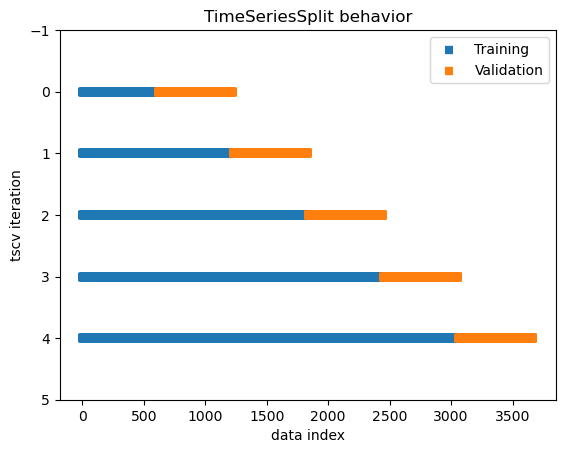

In [25]:
X = df[predictors]
y = df['target']

tscv = TimeSeriesSplit(n_splits=5)

fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(tscv.split(X, y)):
    l1 = ax.scatter(tr, [ii] * len(tr), c='tab:blue',
                    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c='tab:orange',
                    marker='_', lw=6)
ax.set(ylim=[5, -1],
       title='TimeSeriesSplit behavior',
       xlabel='data index', ylabel='tscv iteration')
ax.legend([l1, l2], ['Training', 'Validation'])
plt.show()

In [26]:
def scores(model, X, y):
    scores = cross_validate(model, X, y, cv=tscv, scoring=('roc_auc', 'f1'))
    print(f"area under ROC: {scores['test_roc_auc']}")
    print(f"mean area under ROC: {scores['test_roc_auc'].mean()}", end='\n\n')
    print(f"F1: {scores['test_f1']}")
    print(f"mean F1: {scores['test_f1'].mean()}")

### Model 1: K-nearest neighbors -- mean roc_auc: 0.8, mean f1: 0.659

In [27]:
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, 
                                n_features_to_select=10, 
                                direction="forward",
                                cv=tscv,
                                scoring='roc_auc',
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=10, n_jobs=1, scoring='roc_auc')

In [28]:
predictors_knn = list(np.array(predictors)[sfs.get_support()])

scores(knn, df[predictors_knn], df['target'])

area under ROC: [0.76160956 0.80239493 0.79577354 0.81848217 0.82293476]
mean area under ROC: 0.8002389907744625

F1: [0.61502347 0.64622642 0.65296804 0.69130435 0.68949772]
mean F1: 0.6590039981046976


### Model 2: Random forest -- mean roc_auc: 0.877, mean f1: 0.712

In [29]:
rf = RandomForestClassifier(n_estimators=50,
                            min_samples_split=10,
                            random_state=1)
sfs = SequentialFeatureSelector(rf, 
                                n_features_to_select=10, 
                                direction="forward",
                                cv=tscv,
                                scoring='roc_auc',
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=RandomForestClassifier(min_samples_split=10,
                                                           n_estimators=50,
                                                           random_state=1),
                          n_features_to_select=10, n_jobs=1, scoring='roc_auc')

In [30]:
predictors_rf = list(np.array(predictors)[sfs.get_support()])

scores(rf, df[predictors_rf], df['target'])

area under ROC: [0.84457388 0.88147381 0.87704733 0.89945182 0.88312606]
mean area under ROC: 0.8771345802025401

F1: [0.66992665 0.70673077 0.69194313 0.76388889 0.72941176]
mean F1: 0.7123802402308748


### Model 3: Ridge classifier -- mean roc_auc: 0.917, mean f1: 0.773

In [31]:
rc = RidgeClassifier(alpha=0.1)
sfs = SequentialFeatureSelector(rc, 
                                n_features_to_select=10, 
                                direction="forward",
                                cv=tscv,
                                scoring='roc_auc',
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=RidgeClassifier(alpha=0.1),
                          n_features_to_select=10, n_jobs=1, scoring='roc_auc')

In [32]:
predictors_rc = list(np.array(predictors)[sfs.get_support()])

scores(rc, df[predictors_rc], df['target'])

area under ROC: [0.89649613 0.91839954 0.92005542 0.93456009 0.91627875]
mean area under ROC: 0.9171579861119727

F1: [0.74439462 0.77958237 0.76781609 0.78800857 0.78733032]
mean F1: 0.7734263918860009


### Model 4: Support vector classifier -- mean roc_auc: 0.898, mean f1: 0.728

In [33]:
from sklearn.svm import SVC

svc = SVC()
sfs = SequentialFeatureSelector(svc, 
                                n_features_to_select=10, 
                                direction="forward",
                                cv=tscv,
                                scoring='roc_auc',
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=SVC(), n_features_to_select=10, n_jobs=1,
                          scoring='roc_auc')

In [34]:
predictors_svc = list(np.array(predictors)[sfs.get_support()])

scores(svc, df[predictors_svc], df['target'])

area under ROC: [0.86181506 0.90014968 0.90232501 0.92611    0.90199518]
mean area under ROC: 0.8984789869939223

F1: [0.6797066  0.6962963  0.73903002 0.78867102 0.73563218]
mean F1: 0.7278672257462329


## Tuning hyperprameters

In [35]:
params = {'alpha': [round(a * 0.1, 1) for a in range(1, 11)]}

gs = GridSearchCV(rc,
                  param_grid=params,
                  scoring='roc_auc',
                  cv=tscv)
gs.fit(X[predictors_rc], y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RidgeClassifier(alpha=0.1),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             scoring='roc_auc')

In [36]:
gs.best_params_

{'alpha': 0.3}

## Conclusion

As a final note, we'll look at how well our best model can predict the last season of Bundesliga using the previous five seasons.

In [37]:
rc = RidgeClassifier(alpha=0.3)

train = df[df['date'] < '2022-07-01']
test = df[df['date'] > '2022-07-01']

rc.fit(train[predictors_rc], train['target'])

scores(rc, test[predictors_rc], test['target'])

area under ROC: [0.80747016 0.90830592 0.89277601 0.94048181 0.92239859]
mean area under ROC: 0.8942864985568137

F1: [0.75213675 0.79012346 0.76712329 0.75471698 0.69767442]
mean F1: 0.752354979266967


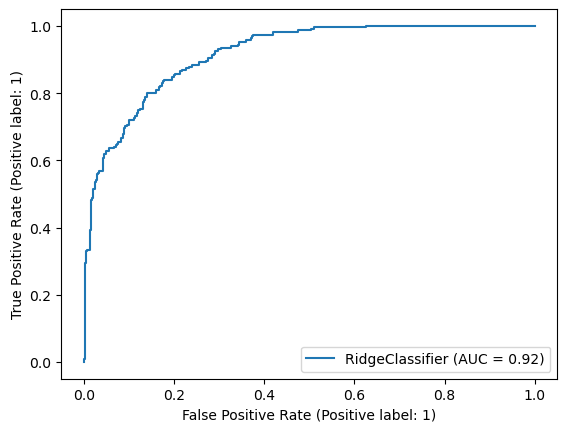

In [38]:
plot_roc_curve(rc, test[predictors_rc], test['target'])
plt.show()

In [39]:
print(classification_report(test['target'],
                            rc.predict(test[predictors_rc]))
)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       381
           1       0.78      0.80      0.79       231

    accuracy                           0.84       612
   macro avg       0.83      0.83      0.83       612
weighted avg       0.84      0.84      0.84       612



In [40]:
df['target'].value_counts()

0    2287
1    1382
Name: target, dtype: int64

Our model seems to be doing better when it comes to negative prediction. This makes sense since our target set contains much more negative outcomes than positive ones as a result of our labeling both draws and losses as 0's.